In [1]:
import csv
import matplotlib.pyplot as plt
import nltk
import pandas
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import tree
from sklearn import metrics

pandas.set_option('display.max_rows', 10000)

# loading the dataset
dataset = pandas.read_csv("newDataset.csv",sep=',',usecols=['tweet','label'])
dataset.tweet=dataset.tweet.str.lower()
#print(type(dataset))
#print(f"Number of tweets: {len(dataset)}")
display(dataset)
#dataset

,tweet,label
0,vaccini: il successo della brexit premetterà a...,1
1,aifa autorizza il vaccino astrazeneca ma ne ra...,1
2,vaccini mentre l'eu cerca (tra l'altro senza s...,0
3,si andrebbe presumibilmente ben oltre l'anno. ...,2
4,"oggi 30 gennaio , ho ricevuto la seconda dose ...",1
5,"in realtà, soprattutto nel caso di confronto c...",2
6,quale sarebbe il vantaggio del nuovo vaccino t...,0
7,firewall76 nicolatosti1 scaltritilab rominafuo...,0
8,vaccino vaccini vaccinocovid mammamia bambini ...,0
9,antonellaviol17 dipende. cosa succederà se avr...,1


In [2]:
italian_stemmer = SnowballStemmer('italian')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([italian_stemmer.stem(w) for w in analyzer(doc)])

In [3]:
X_train, X_test, y_train, y_test = train_test_split(dataset.tweet, dataset.label, test_size=0.3)

In [4]:
#counting the word occurrences,it includes tokenization and stopword filtering, check parameters
count_vect = StemmedCountVectorizer(min_df=2, analyzer="word",ngram_range=(1,2), stop_words = set(stopwords.words('italian')))
#count_vect = CountVectorizer(stop_words=stopwords,analyzer=stemming,min_df=2)

X_train_counts = count_vect.fit_transform(X_train)
#extracted tokens
#print(count_vect.get_feature_names())
  
# Text rapresentation supervised stage on training set, include calculation of TFs (frequencies)
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)  
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# TF-IDF extraction on test set, tokenization and word counting,feature extraction
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [5]:
def evaluate_classifier(clf):
    clf.fit(X_train_tfidf, y_train)
    #Evaluation on test set
    predicted = clf.predict(X_test_tfidf)#prediction
    #Extracting statistics and metrics
    accuracy=np.mean(predicted == y_test)#accuracy extreaction
    print('accuracy : ' + str(accuracy))

    f_score = f1_score(y_test, predicted, average='macro')
    print('f_score : ' + str(f_score) + '\n')
    
    disp = plot_confusion_matrix(clf, X_test_tfidf, y_test, cmap=plt.cm.Blues, normalize='true')
    disp.ax_.set_title('Confusion Matrix')
    plt.show()

Multinomial NB:
accuracy : 0.4966887417218543
f_score : 0.47149933657673593



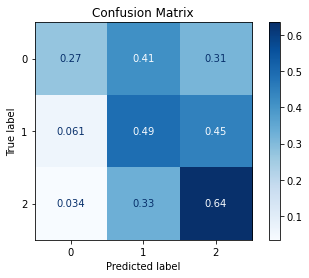

Decision Tree:
accuracy : 0.4304635761589404
f_score : 0.42947049649008134



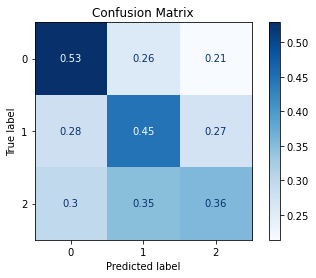

SVM:
accuracy : 0.5198675496688742
f_score : 0.5142099766802665



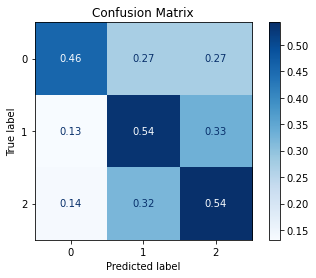

k-NN (k = 5) :
accuracy : 0.47019867549668876
f_score : 0.4693614076989335



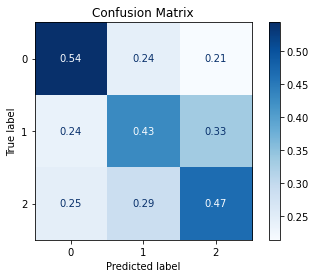

Adaboost:
accuracy : 0.3841059602649007
f_score : 0.36076473888208893



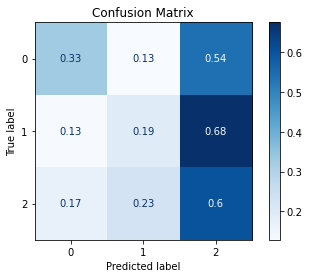

Random Forest:
accuracy : 0.4867549668874172
f_score : 0.4779552152868258



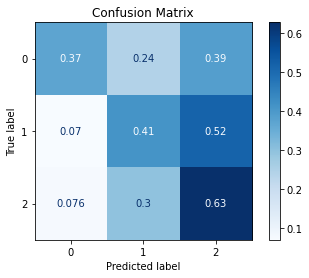

In [6]:
#Training the classifiers

# --------------- BAYESS ---------------
clf1 = MultinomialNB()
print('Multinomial NB:')
evaluate_classifier(clf1)

# --------------- DECISION TREE ---------------
clf2 = tree.DecisionTreeClassifier()
print('Decision Tree:')
evaluate_classifier(clf2)

# --------------- SVC ---------------
clf3 = svm.LinearSVC()
print('SVM:')
evaluate_classifier(clf3)

# --------------- K-NN ---------------
k_neighbor = 5
clf4 = KNeighborsClassifier(k_neighbor)
print('k-NN (k = ' + str(k_neighbor) + ') :')
evaluate_classifier(clf4)

# --------------- ADABOOST ---------------
clf5 = AdaBoostClassifier()
print('Adaboost:')
evaluate_classifier(clf5)

# --------------- RANDOM FOREST ---------------
clf6 = RandomForestClassifier()
print('Random Forest:')
evaluate_classifier(clf6)